In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import pickle


import psutil
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2,3,4,5,6,7,8,9 ])

os.chdir(r'H:\all\RL_Shrinkage_2024')
from helpers import helper_functions as hf
from ONE_YR.NonLinear_Shrinkage import regression_evaluation_funcs as re_hf
from helpers import eval_function_new


In [2]:
PF_SIZE = 500


base_folder_path = r'H:\\all\\RL_Shrinkage_2024'
# IMPORT SHRK DATASETS
pf_size = PF_SIZE  # DONT CHANGE HERE!!
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\returns_full_1Y_p{pf_size}.pickle")


fixed_shrk_name = 'cov1Para'
opt_shrk_name = 'cov1Para'
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\{opt_shrk_name}_factor-1.0_p{pf_size}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)

with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_rawres_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    rawres_fixed_shrk_data = pickle.load(f)

# IMPORT FACTORS DATA AND PREPARE FOR FURTHER USE
factor_path = fr"{base_folder_path}\helpers"
factors = pd.read_csv(factor_path + "/all_factors.csv")
factors = factors.pivot(index="date", columns="name", values="ret")

# as our shrk data starts from 1980-01-15 our factors data should too
start_date = str(optimal_shrk_data['date'].iloc[0])
start_date = start_date[0:4] + '-' + start_date[4:6] + "-" + start_date[6:]
start_idx = np.where(factors.index == start_date)[0][0]
factors = factors.iloc[start_idx:start_idx+fixed_shrk_data.shape[0], :]

cov1para_shrk = optimal_shrk_data['shrk_factor'].values[5040:]

len_train = 5040
end_date = fixed_shrk_data.shape[0]
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]

In [3]:
all_res = fixed_shrk_data.iloc[:, 2:].copy() * 100
all_factors = all_res.columns.astype(float).values
Y = all_res.idxmin(axis=1).values.astype(float)
opt_values = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(0.15, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, all_res.idxmin(axis=1).values])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values


ROLL_WINDOW = 1
ROLL_WINDOW_INPUTS = 252
rolling_opt = pd.Series(opt_values).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values

Y = pd.Series(Y).rolling(window=1, min_periods=1).mean().astype(np.int64).values
opt_values = pd.Series(opt_values).rolling(window=1, min_periods=1).mean().astype(np.int64).values



In [4]:
params = {
'pf_size' : pf_size,
'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': False,
'include_factors': False,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
    'additional_inputs' : [opt_v3, rolling_opt, rolling_opt2, optimal_shrk_data['shrk_factor'].values.astype(np.float64)*100]  
}

X = re_hf.load_additional_train_data(**params)

#### Evaluate best model on OOS data

10.478636673561944

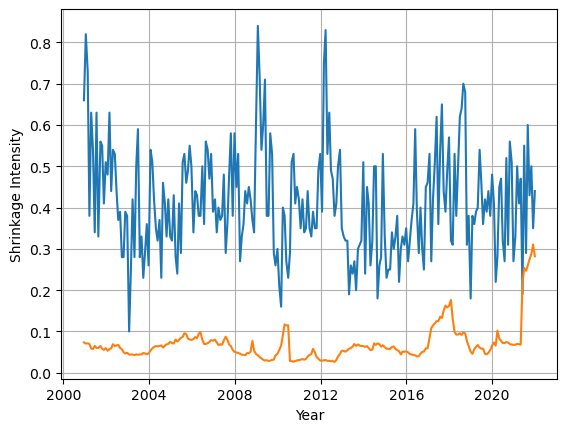

In [6]:
res = re_hf.general_single_output_RF_Lagged(X=X, Y=Y, len_train=len_train)
res = [r if r > 0 else 0 for r in res]
res = [r if r < all_factors.shape[0] else all_factors.shape[0]-1 for r in res]

mapped_res = np.array(re_hf.map_preds_to_factors(res, all_factors)).astype(float)
#r = eval_function_new.eval_fct_networkonly_1YR(mapped_res, rets_full, permnos, 0, val_indices_results)
#eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

res_df = pd.DataFrame({"RF": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

### Backtest baseline "last optimal"

10.762069228916737

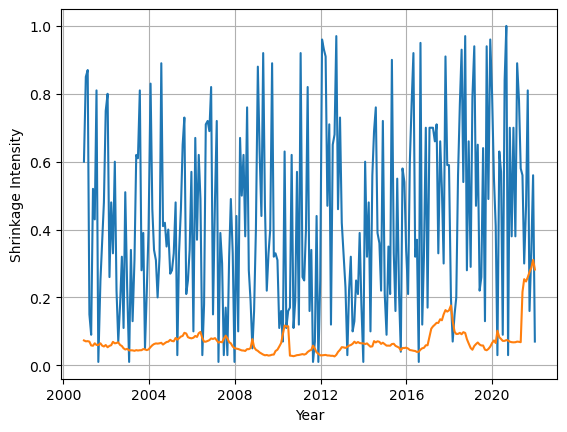

In [25]:
res = general_single_output_last_optimal_Lagged(X=X, Y=Y, len_train=len_train)
res = [r if r > 0 else 0 for r in res]
res = [r if r < all_factors.shape[0] else all_factors.shape[0]-1 for r in res]

mapped_res = np.array(re_hf.map_preds_to_factors(res, all_factors)).astype(float)
#r = eval_function_new.eval_fct_networkonly_1YR(mapped_res, rets_full, permnos, 0, val_indices_results)
#eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

res_df = pd.DataFrame({"last optimal": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

In [24]:
def general_single_output_last_optimal_Lagged(X, Y, len_train, single_train=False, expanding=False, train_size=None,
                                    model_params={} ):

    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else:  # TRAINING
            if single_train == False:
                if expanding == False:
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), ]
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), ]
            else:
                if i == 0:
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), ]
            ## TRAINING DONE
            x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))

            preds = y_train[-1]
            preds = int(np.round(preds, 0))

            #print(f"fitted model in iteration {i} out of {5313//21}")
            model_predictions.append(preds)